# **<u>Part 3</u>:** The best of two worlds: fast and readable Python.

### 

### A GitHub analysis shows that `Python` is among the most expressive
### general purpose programming languages in existence.
### 
### Expressiveness means fewer lines of code and fewer changes per commit.
### 
### Expressiveness comes at a cost: <u>performance</u>.
### 
### Python is <u>slow</u>. Very slow. A pure `Python` implementation is typically
### $\sim 10$ to $\sim 100$ times slower than an equivalent `C` implementation, for instance.
### 
### Then why is `Python` arguably the most important language in scientific computing,
### a domain wherein performance matters the most ?

### 
### 
### 
### 
### 1. It is a misconception that performance matters a lot in scientific computing.
### Usually, readability (`Python` is closest to `pseudocode`) > performance (debatable).
### 
### 2. The `Python` programming language is one of the best suited languages for interfacing
### performant languages (`Cython`, `Fortran`, `C`, `C++`, `Rust`, ...).
### This has lead to a very rich ecosystem of quite performant scientific computing libraries
### (`Numpy`, `Scipy`, `PyTorch`, ...) that combine the readability and ease of use of `Python`
### with the performance of a compiled language (usually `C` or `Fortran`).
### 
### Some say that `Python` is the _glue_ that holds all other languages together.
### 
### This lecture teaches us the use of `Python` built-in and external modules that can speed up
### our code considerably, without sacrificing too much readability.
### 
### Before we venture on, here some artwork:
### 
<img src="img/tree_final.png" alt="Drawing" width="700"/>

### 

### 
### <u>My code is slow. What should I do</u> ?!?
### 
### Here, a very subjective hierarchy of steps you can take:
### 
### 1. Have a beer (arguably the most comfortable solution).
### 2. Improve your `Numpy` skills or write a parallelised code in `Python`.
### 3. Use `JIT`-compiled libraries like `Numba` (general purpose) or `JAX` (anything related to optimisation).
### 4. Learn the creole language `Cython`.
### 5. Use the `ctypes` built-in module to interface a `C` code.
### 6. Interface `C++`, `Rust`, `Fortran`, `...`
### 
### If you find you need `C++` instead of `C / Cython / Numba`, you might soon reach a point 
### where it makes sense to rewrite everything in `C++`, and the 
### `Python` interface becomes a mere afterthought.
### 
### <u>Remember</u>: 
### Each optimisation may sacrifice readability / flexibility. 
### Use it with care. Often you will find, you actually don't really need it.
### 
### _"Premature optimization is the root of all evil."_
### - Donald Knuth
### 
### _"Python where we can, C where we must."_
### - Sergey Brin (Google)
### 
<hr style="border:1px solid blue">

### 
# <u>Lesson 1</u>:
## Advanced `Numpy` concepts.
### 
### Once you grow tired of the _'have a beer'_ solution, the next step you should take is pimping your use of `Numpy`.
### <u>Here is why</u>: making good use of `Numpy` does not only speed up your code, it also typically makes it more `readable`.
### 
### Check this out:

In [ ]:
import numpy as np
from typing import Sequence

"""
  Four different functions that operate on an array
  of shape (n0, n1, ..., nM-1, nM) and return an array of shape
  (n0, n1, ..., nM-1) that takes the l2 norm along the last axis.
  
  The shape of the array (number of dimensions) is only known at runtime.
"""

### BAD implementations first

# the non-idiomatic implementation requires a number of fail checks to work exactly right
def compute_l2_norm_along_last_axis_very_bad(arr: np.ndarray | Sequence) -> np.ndarray:
  # remember, you have no idea what the shape of the array is
  arr = np.asarray(arr)  # do local coercion
  assert (y := arr.ndim) >= 1, f"Expected the array to have at least one dimension."
  shape = arr.shape  # (n0, n1, .., nM)
  
  # Since we don't know the number of dimensions,
  # we have to flatten the first couple of axes 
  # believe me, a lot of people do this ...
  arr = arr.reshape((np.prod(shape[:-1]), shape[-1]))
  
  ret = np.zeros(arr.shape[:-1], dtype=float)
  
  for i in range(len(ret)):
    val = 0.0
    for j in range(len(arr[i])):
      val += arr[i, j] ** 2
      
    ret[i] = val ** .5
  
  return ret.reshape(shape[:-1])  # reshape 


def compute_l2_norm_along_last_axis_bad(arr: np.ndarray | Sequence) -> np.ndarray:
  # a bit better
  arr = np.asarray(arr)
  shape = arr.shape
  
  arr = arr.reshape((-1, shape[-1]))  # -1 infers the remaining dimension
  
  ret = np.empty( arr.shape[:-1], dtype=float )  # allocating empty array is faster than zero array
  
  for i, subarr in enumerate(arr):  # iterate over array directly rather than using a range
    ret[i] = (subarr ** 2).sum() ** .5  # avoid the second for loop using vectorisation
    
  return ret.reshape(shape[:-1])


###

### Now the `good` ones


# We don't need fail checks. Will fail if `arr` doesn't have the right shape.
def compute_l2_norm_along_last_axis_good(arr: np.ndarray) -> np.ndarray:
  return np.sqrt((np.asarray(arr) ** 2).sum(-1))


# idem
compute_l2_norm_along_last_axis_idiomatic = lambda arr: np.linalg.norm(arr, ord=2, axis=-1)


### 
  
  
# an array with some random shape
A = np.random.randn(5, 4, 2, 3, 20)

norm0 = compute_l2_norm_along_last_axis_idiomatic(A)

### check if all implementations give the same outcome
allfuncs = (compute_l2_norm_along_last_axis_very_bad, 
            compute_l2_norm_along_last_axis_bad,
            compute_l2_norm_along_last_axis_good,
            compute_l2_norm_along_last_axis_idiomatic)

print(f"All implementations are the same: {all(np.allclose(norm0, f(A)) for f in allfuncs)}")
### 

### Let's see which one is the fastest:

In [ ]:
%timeit compute_l2_norm_along_last_axis_very_bad(A)
%timeit compute_l2_norm_along_last_axis_bad(A)
%timeit compute_l2_norm_along_last_axis_good(A)
%timeit compute_l2_norm_along_last_axis_idiomatic(A)

### 
### We have two clear winners in terms of readability and speed !
### 
### When you use a `numpy` function like `np.linalg.norm`, there is usually
### an `axis` argument which you can use to perform an operation along an axis.
### 
### `Numpy` programming $\neq$ `Python` programming.
### If you know `Python` you don't automatically know how to use `Numpy`.
### However, if you're really good at `Numpy` you're typically also really good at `Python`.
### 
<hr style="border:1px solid blue">

### 
### We come back to our `derivative.py` code from the `OOP` lecture.
### It's exactly the same code but now I allowed everything to be a vectorised
### `Numpy` operation.

In [ ]:
# %load vector/derivative_vectorised.py
import numpy as np
from matplotlib import pyplot as plt
from typing import Sequence, Tuple, Union, Any, Callable
from abc import abstractmethod
from collections.abc import Hashable

from functools import lru_cache


NumericType = Union[int, float]
FunctionType = Union['DifferentiableFunction', NumericType]
CallInputType = Union[NumericType, np.ndarray, Sequence[NumericType]]


# main function for type coercion
def as_function(func: FunctionType) -> 'DifferentiableFunction':
  """
    func is a DifferentialFunction => return func,
    func is an int or float => return Constant(func),
    func is anything else => this method fails.
  """
  if isinstance(func, DifferentiableFunction):
    return func
  return Constant(func)


@lru_cache
def _derivative(self: 'DifferentiableFunction') -> 'DifferentiableFunction':
  """
  All our classes are hashable. They can be used in combination with lru_cache.
  We call this function in DifferentiableFunction.derivative().
  We will never again compute a derivative twice ;-)
  """
  return self._deriv()


class DifferentiableFunction(Hashable):

  def __init__(self, args: Sequence[Hashable]) -> None:
    self._args = tuple(args)
    self._hash = hash(self._args)

  def __hash__(self) -> int:
    return self._hash

  def __eq__(self, other: Any) -> bool:
    return self.__class__ == other.__class__ and hash(self) == hash(other) and self._args == other._args

  @abstractmethod
  def __call__(self, x: np.ndarray | NumericType | Sequence[NumericType]):
    pass

  @abstractmethod
  def _deriv(self):
    pass

  def derivative(self, n: int = 1) -> 'DifferentiableFunction':
    assert (n := int(n)) >= 0
    if n == 0:
      return self
    # use the cached version.
    return _derivative(self).derivative(n=n-1)

  def plot(self, interval: Tuple[int, int] = (0, 1), npoints: int = 1001) -> None:
    """ Plot function over the interval `interval` using `npoints` function evaluations. """
    a, b = interval
    assert b > a
    x = np.linspace(*interval, 1001)
    y = self(x)
    plt.plot(x, y)
    plt.show()

  def __add__(self, other: FunctionType) -> 'Add':
    "self: DifferentialFunction + other: FunctionType"
    return Add(self, other)

  __radd__ = __add__

  def __mul__(self, other: FunctionType) -> 'Multiply':
    "self: DifferentialFunction * other: FunctionType"
    return Multiply(self, other)

  __rmul__ = __mul__

  def __sub__(self, other: FunctionType) -> 'Add':
    "self: DifferentialFunction - other: FunctionType"
    return self + (-1) * other

  def __rsub__(self, other: NumericType) -> 'Add':
    """
      other: NumericType - self: DifferentialFunction.
      Here, the -1 has to go in front of self.
      other - self => self.__rsub__(other).
    """
    return other + (-1) * self


class Constant(DifferentiableFunction):

  def _deriv(self) -> 'Constant':
    return Constant(0)

  def __init__(self, value: NumericType) -> None:
    self.value = float(value)
    super().__init__([self.value])

  def __call__(self, x: CallInputType) -> float:
    return self.value


class Argument(DifferentiableFunction):

  def _deriv(self) -> Constant:
    return Constant(1)

  def __init__(self) -> None:
    super().__init__([])

  def __call__(self, x: CallInputType) -> np.ndarray:
    return np.asarray(x, dtype=float)


class Add(DifferentiableFunction):

  def _deriv(self) -> 'Add':
    return self.f0.derivative() + self.f1.derivative()

  def __init__(self, f0: FunctionType, f1: FunctionType) -> None:
    self.f0, self.f1 = sorted(map(as_function, (f0, f1)), key=lambda x: (x.__class__.__name__, hash(x)))
    super().__init__([self.f0, self.f1])

  def __call__(self, x: CallInputType) -> np.ndarray:
    return self.f0(x) + self.f1(x)


class Multiply(DifferentiableFunction):

  def _deriv(self) -> Add:
    return self.f0.derivative() * self.f1 + self.f0 * self.f1.derivative()

  def __init__(self, f0: FunctionType, f1: FunctionType) -> None:
    self.f0, self.f1 = sorted(map(as_function, (f0, f1)), key=lambda x: (x.__class__.__name__, hash(x)))
    super().__init__([self.f0, self.f1])

  def __call__(self, x: CallInputType) -> np.ndarray:
    return self.f0(x) * self.f1(x)


class ChainRule(DifferentiableFunction):

  evalf: Callable
  df: Callable

  def _deriv(self) -> DifferentiableFunction:
    return self.df(self.argument) * self.argument.derivative()

  def __init__(self, argument: FunctionType) -> None:
    assert all(hasattr(self, item) for item in ('evalf', 'df')), 'Each derived class needs to implement `evalf` and `df`.'
    self.argument = as_function(argument)
    super().__init__([self.argument])

  def __call__(self, x: CallInputType) -> np.ndarray:
    return self.evalf(self.argument(x))


class Exp(ChainRule):
  evalf = np.exp
  df = lambda self, argument: self


class Sin(ChainRule):
  evalf = np.sin
  df = lambda self, argument: Cos(argument)


class Cos(ChainRule):
  evalf = np.cos
  df = lambda self, argument: (-1) * Sin(argument)


# make an argument f(x) = x
x = Argument()

# choose some c0, c1
c0, c1 = 2, 1

# make the damping term
exp = Exp(-.5 * x)

# define the natural frequency
w0 = 3 * np.sqrt(11) / 2

# create y(x) using syntactic sugar
y = c0 * exp * Sin(w0 * x) + c1 * exp * Cos(w0 * x)

complex_func = 25 * y + y.derivative() + y.derivative(2) + y.derivative(3) + y.derivative(4)

### 
### We time the vectorised and the non-vectorised versions

In [ ]:
xi = np.linspace(0, 1, 1001)
import time

t0 = time.time()
complex_func(xi)
t1 = time.time()
print(f"Vectorised operation took {t1 - t0} seconds.\n")

t0 = time.time()
[complex_func(_xi) for _xi in xi]
t1 = time.time()
print(f"for loop took {t1 - t0} seconds.\n")

### 
### You don't really need custom compilation here. `Numpy` is fast enough for this task.

### 
<hr style="border:1px solid blue">

### 

### In the following, a quick wrap-up of the basics of `numpy`. Since this is an _advanced_
### `Python` course, I assume that everyone has some familiarity.
### 

### The most important tool that `numpy` gives us is the `numpy.newaxis` variable which is
### a convenient alias for `None`. For improved readability it is very common to set `_ = np.newaxis`. 
### 

In [ ]:
import numpy as np

_ = np.newaxis

print(f"_ == np.newaxis == None ? {_ == np.newaxis == None}.")

### 
### The `_` variable allows us to create a new `artificial` axis, which creates an axis of
### dimension `1` at the spot where we put it.
### 

In [ ]:
A = np.random.randn(2, 3)

print(f"         A.shape:    {A.shape}.\n")
print(f"      A[_].shape: {A[_].shape}.\n")
print(f"   A[:, _].shape: {A[:, _].shape}.\n")
print(f"A[:, :, _].shape: {A[:, :, _].shape}.\n")
print(f" A[..., _].shape: {A[..., _].shape}.\n")

### 
### Here the `Ellipsis` variable `...` _infers_ all remaining dimensions.

### 
<hr style="border:1px solid blue">

### 
### When we perform an operation between two `np.ndarray`'s of shape
### `(n0, n1, ..., nM)` and
### `(m0, m1, ..., mM)`
### the output shape is: 
### `(max(n0, m0), max(n1, m1), ..., max(nM, mM))`. 
### If `ni != mi` then either `ni == 1` or `mi == 1` must hold.
### 
### Let's suppose for now that there are no `1` axes. The following code
### roughly reproduces a vectorised operation using some `np.ufunc`
### (but is a trillion times slower):
### 

In [ ]:
import numpy as np
from typing import Callable
from itertools import product


def numpy_equivalent_ufunc_operation(arr0: np.ndarray, arr1: np.ndarray, ufunc: np.ufunc) -> np.ndarray:
  assert arr0.shape == arr1.shape and 1 not in arr0.shape, NotImplementedError
  # we are also assuming that the data type is `float` for convenience
  ret = np.empty(arr0.shape, dtype=float)
  
  # iterate over all combinations (i0, i1, i2, ...) from our shape
  for multi_index in product(*map(range, arr0.shape)):
    ret[multi_index] = ufunc(arr0[multi_index], arr1[multi_index])
    
  return ret


arr0 = np.random.randn(2, 3, 4)
arr1 = np.random.randn(2, 3, 4)

print(f"np.add(arr0, arr1) is equal to our implementation ? {np.allclose(np.add(arr0, arr1), numpy_equivalent_ufunc_operation(arr0, arr1, np.add))}.")

### 
### What changes when we DO allow for `1` axes ?
### For an implementation, see below:
### 

In [ ]:
import numpy as np
from typing import Callable, Tuple
from itertools import product

_ = np.newaxis


def truncate_multi_index(multi_index: Tuple[int, ...], shape: Tuple[int, ...]) -> Tuple[int, ...]:
  """
    (1, 2, 1, 4, 5), (2, 3, 3, 6, 7) -> (1, 2, 1, 4, 5)
    (1, 2, 1, 4, 5), (2, 3, 3, 1, 1) -> (1, 2, 1, 0, 0)
    
    ...
    
    ETC
  """
  return tuple( i if j != 1 else 0 for (i, j) in zip(multi_index, shape, strict=True) )


def numpy_equivalent_ufunc_operation(arr0: np.ndarray, arr1: np.ndarray, ufunc: np.ufunc) -> np.ndarray:
  assert all( i == j or 1 in (i, j) for i, j in zip(arr0.shape, arr1.shape, strict=True) )
  
  shape = tuple(map(max, zip(arr0.shape, arr1.shape)))  # output shape

  ret = np.empty(shape, dtype=float)
  
  # iterate over all combinations (i0, i1, i2, ...) from our shape
  for multi_index in product(*map(range, shape)):
    ret[multi_index] = ufunc( 
                              arr0[ truncate_multi_index(multi_index, arr0.shape) ],
                              arr1[ truncate_multi_index(multi_index, arr1.shape) ]
                            )
    
  return ret


arr0 = np.random.randn(2, 3, 4)[:, _]
arr1 = np.random.randn(2, 3, 4)[:, :, _]

print(f"np.add(arr0, arr1) is equal to our implementation ? {np.allclose(np.add(arr0, arr1), numpy_equivalent_ufunc_operation(arr0, arr1, np.add))}.")

### 
### Let `arr` of shape `(n0, ..., nN-1, nN, ..., nM)` be cast to 
###     `arr_` of shape `(n0, ..., nN-1, 1, nN, ..., nM)`.
### 
### `Numpy` then broadcasts `arr_` such that
### `arr_[i0, ..., iN-1, j, iN, ..., iM] == arr[i0, ..., iN-1, iN, ..., iM]`
### for all `j` that are smaller than `pj` in the output shape `(..., pj, ...)`.
### 
### When the dimension of the arrays we work with is small, it is helpful to visualize
### things as follows:

In [ ]:
import numpy as np
_ = np.newaxis

arr0 = np.random.randn(3)
arr1 = np.random.randn(5)

outer_diff = arr0[:, _] - arr1[_, :]   # has shape (3, 5)

print(f"arr0[:, _] is broadcast to: \n\n{np.broadcast_to(arr0[:, _], outer_diff.shape)}.\n")
print(f"arr1[_, :] is broadcast to: \n\n{np.broadcast_to(arr1[_, :], outer_diff.shape)}.\n")

### 
### When the number of dimensions is larger, it is better to think in terms of shapes.
### 
<hr style="border:1px solid blue">

### 
## <u> Exercise 1.1 </u>:
### Given an array `arr0` of shape `(p, n)` and `arr1` of shape `(q, n)`, compute the
### matrix `dist` of shape `(p, q)` containing all Euclidean distances between the
### row vectors of `arr0` and `arr1`. You're not allowed to use `np.linalg.norm` ;-)
### 
### `dist[i, j]` = `|| arr0[i, :] - arr1[j, :] ||`.
### 

### **HINT**:
### `(p, n)` and `(q, n)` become
### `(p, 1, n)` and `(1, q, n)` become 
### `(p, q, n)` and `(p, q, n)` becomes
### `(p, q)`.
### 
### <u>solution</u>:

In [ ]:
import numpy as np

_ = np.newaxis

p, q, n = 4, 6, 10

arr0 = np.random.randn(p, n)
arr1 = np.random.randn(q, n)

### all equivalent
dist0 = ((arr0[:, _, :] - arr1[_, :, :])**2).sum(-1) ** .5

# We can leave out the trailing colons `:`. Numpy will infer them.
dist1 = ((arr0[:, _] - arr1[_])**2).sum(-1) ** .5

# np.sqrt(x) is a tad faster than x ** .5 because it's optimised for square root only.
dist2 = np.sqrt( ((arr0[:, _] - arr1[_])**2).sum(-1) )

print(f"All are equivalent ? {np.allclose(dist0, dist1) and np.allclose(dist1, dist2)}")

### 
### Thinking in terms of shapes is no longer optional when the dimension of the
### broadcast arrays exceeds $3$ (unless you came to visit us in our _flatland_ from a higher-dimensional universe).
### 
### Luckily, this trick works in **the vast majority of cases** (and is therefore what I recommend you shoud do).
### 
<hr style="border:1px solid blue">

### 
### 
### We continue with another (preparational)
## <u> Exercise 1.2 </u>:
### Given arrays `arr0, arr1` of shape `(p, n)` and `(n, q)`, implement matrix multiplication
### using vectorisation (don't use `@` or `np.matmul`).
### 
### <u>solution</u>:

In [ ]:
import numpy as np
_ = np.newaxis

p, q, n = 4, 6, 10

arr0 = np.random.randn(p, n)
arr1 = np.random.randn(n, q)

# (p, n) and (n, q) becomes
# (p, n, 1) and (1, n, q) becomes
# (p, n, q) and (p, n, q) becomes
# (p, q)

### two equivalent ones
matmul0 = (arr0[:, :, _] * arr1[_, :, :]).sum(1)

matmul1 = (arr0[..., _] * arr1).sum(1)

matmul = arr0 @ arr1
print(f"matmul0 and matmul1 are both equal to matmul0 @ matmul1 ? {np.allclose(matmul0, matmul) and np.allclose(matmul1, matmul)}")

### 
### 
### 
### 
### 
### The big question is: why were we allowed to do `(arr0[..., _] * arr1)` ?
### `arr0[..., _]` has three dimensions `(p, n, 1)` while `arr1` has two `(n, q)` ?!?
### 
### $\implies$ If one array is _shorter_ than the other, `Numpy` prepends as many `1` axes as necessary !
### `(p, n, 1)` and `(n, q)` becomes `(p, n, 1)` and `(1, n, q)`.
### 
<hr style="border:1px solid blue">

### 
### Now suppose you have an array of dimension `N` and you would like to add an artificial axis at the
### `m`-th spot, with `m` < `N`. However you know `m` only at runtime. What do you do ?
### 
### You have to somehow pass `m` colons `:` into the array brackets and then a new axis.
### For instance, `arr.shape == (3, 4, 5, 6, 7, 2, 2)` and `m == 3`
### $\implies$ `arr[:, :, :, _].shape == (3, 4, 5, 1, 6, 7, 2, 2)`.
### 
### Here is how you can do that:

In [ ]:
import numpy as np

_ = np.newaxis

# this guy is equivalent to a colon `:`
sl = slice(None)


def add_axis_m(arr: np.ndarray, m: int) -> np.ndarray:
  # m colons plus a new axis =)
  return arr[ (sl,) * m + (_,) ]


A = np.random.randn(3, 4, 5, 6, 7, 2, 2)

print(f"A has shape: {A.shape}.\n")
print(f"Adding new axis to `A` at the 3rd spot gives shape: {add_axis_m(A, 3).shape}. \n")
print(f"Adding new axis to `A` at the 5th spot gives shape: {add_axis_m(A, 5).shape}.")

### 
### Actually not that difficult ;-)
### 
<hr style="border:1px solid blue">

### 
### Now that we know how to multiply matrices using vectorisation and how to add axes in specific spots,
### we will challenge ourselves a bit more.
### 
## <u>Exercise 1.3</u>:
### Given two arrays `arr0` and `arr1`, both of unknown dimension `N`.
### Compute an array `matmul_m` that performs `matrix multiplication` along axes numbers `m` and `m+1`, with `m+1 < N`.
### 
### I.e., `matmul_m` satisfies: 
### `//   matmul_m[i0, ..., i_(m-1),| :, :,| i_(m+2), ..., iN]`
### `// =     arr0[    ...          | :, :,|          ...    ]`
### `//     @ arr1[    ...          | :, :,|          ...    ]`.
### This problem is solved by **thinking in terms of shapes !!**
### 
### 
### <u>HINT</u>: here is what needs to happen (focus on the part between the `|   |`):
### `(n0, ..., n_(m-1),| p, n,    | n_(m+2), ..., nN)` and 
### `(n0, ..., n_(m-1),|    n, q, | n_(m+2), ..., nN)` 
### becomes
### `(    ...          | p, n, 1, |          ...    )` and 
### `(    ...          | 1, n, q, |          ...    )` 
### becomes
### `(    ...          | p, n, q, |          ...    )` and 
### `(    ...          | p, n, q, |          ...    )` 
### becomes
### `(n0, ..., n_(m-1),| p,    q, | n_(m+2), ..., nN)`.
### 
### Compared to our previous implementation, there is a `head` and a `tail` we have to carry around.
### 
### <u>Template</u>:

In [ ]:
import numpy as np

_ = np.newaxis
sl = slice(None)


def perform_matmul_m(arr0: np.ndarray, arr1: np.ndarray, m: int) -> np.ndarray:
  assert arr0.ndim == arr1.ndim and m + 1 < arr0.ndim
  return # ??? YOUR ONE-LINER HERE


m = 3
arr0 = np.random.randn(3, 4, 5, 6, 7, 2, 2)
arr1 = np.random.randn(3, 4, 5, 7, 3, 2, 2)
matmul_3 = perform_matmul_m(arr0, arr1, 3)

print(f"                arr0 has shape: {arr0.shape}.\n")
print(f"                arr1 has shape: {arr1.shape}.\n")
print(f"matmul_m with m == 3 has shape: {matmul_3.shape}. \n\n")

multi_index = (0, 0, 0, sl, sl, 0, 0)
print(f"multi_index equals: {multi_index}.\n")

print(f"matmul_3[multi_index] equals arr0[multi_index] @ arr1[multi_index] ? {np.allclose(matmul_3[multi_index], arr0[multi_index] @ arr1[multi_index])}.")

### <u>solution</u>:

In [ ]:
import numpy as np

_ = np.newaxis
sl = slice(None)


def perform_matmul_m(arr0: np.ndarray, arr1: np.ndarray, m: int) -> np.ndarray:
  assert arr0.ndim == arr1.ndim and m + 1 < arr0.ndim
  # arr0[ (m + 2) colons and a new axis ]
  # arr1[  m      colons and a new axis ]
  return (arr0[ (sl,) * (m+2) + (_,)  ] * arr1[ (sl,) * m + (_,) ]).sum(m+1)


m = 3
arr0 = np.random.randn(3, 4, 5, 6, 7, 2, 2)
arr1 = np.random.randn(3, 4, 5, 7, 3, 2, 2)
matmul_3 = perform_matmul_m(arr0, arr1, 3)

print(f"                arr0 has shape: {arr0.shape}.\n")
print(f"                arr1 has shape: {arr1.shape}.\n")
print(f"matmul_m with m == 3 has shape: {matmul_3.shape}. \n\n")

multi_index = (0, 0, 0, sl, sl, 0, 0)
print(f"multi_index equals: {multi_index}.\n")

print(f"matmul_3[multi_index] equals arr0[multi_index] @ arr1[multi_index] ? {np.allclose(matmul_3[multi_index], arr0[multi_index] @ arr1[multi_index])}.")

### 
<hr style="border:1px solid blue">

### 
### It is worth it to understand `Numpy` better. You'll be surprised by how much stuff
### you can solve by making better use of `Numpy`.
### 
## <u> Task </u>:
### Given an array of arbitrary shape `(n0, ..., nM)`, write a function `normalize(arr)`
### that normalizes `arr` along the last axis `in place` !
### 

In [ ]:
import numpy as np
_ = np.newaxis


def normalize_bad(arr: np.ndarray) -> None:
  
  # ( n0,  n1,  ...,  n_(N-1),   nN) becomes
  # ( n0 x n1 x ... x n_(N-1),   nN)
  arr = arr.reshape( (-1, arr.shape[-1]) )  # view into the same memory
  
  for i, subarr in enumerate(arr):
    arr[i] /= np.linalg.norm(subarr, ord=2)
    
    
def normalize_ok(arr: np.ndarray) -> None:
  norm = np.linalg.norm(arr, ord=2, axis=-1)
  arr[:] = arr / norm[..., _]
  # here it would be better to say arr /= norm[..., _]


def normalize_good(arr: np.ndarray) -> None:
  np.divide(arr, np.linalg.norm(arr, ord=2, axis=-1, keepdims=True), out=arr)
  
  
  
A = np.random.randn(4, 3, 2, 6, 10)

A0 = A.copy()
normalize_bad(A0)

A1 = A.copy()
normalize_ok(A1)

A2 = A.copy()
normalize_good(A2)

print(f'All three implementations give the same value: {all(np.allclose(A0, Ai) for Ai in (A1, A2))}.')

In [ ]:
%timeit normalize_bad(A)
%timeit normalize_ok(A)
%timeit normalize_good(A)

### 
### The last two implementations are an order of magnitude faster because they avoid the for loop.
### 
### The third implementation is a tad faster than the second because:
### 1. The line `arr[:] = arr / norm[..., _]` actually creates a new array `y := arr / norm[..., _]`
### which is then copied back into `arr`.
### 2. The broadcast `norm[..., _]` creates a slight overhead.
### 
### In the last implementation, we avoided the broadcast by passing `keepdims=True` in the `np.linalg.norm`
### function. Each function that performs an axis reduction has this keyword argument. It works as follows:
### 
### `reduction_func(arr, axis=(2, 4, 5))`:
### shape `(2, 3, 4, 2, 5, 6, 6)` becomes `(2, 3, 2, 6)`
### 
### `reduction_func(arr, axis=(2, 4, 5), keepdims=True):`
### shape `(2, 3, 4, 2, 5, 6, 6)` becomes `(2, 3, 1, 2, 1, 1, 6)`.

### 
### The `keepdims=True` keyword is very helpful for vectorisation.
### 

### More importantly: in the `np.divide` function we passed `out=arr` which avoids allocating new memory
### but performs the operation into the existing array `arr` we passed.
### 

### It is worth studying the the extra arguments of `np.ufunc`'s. 
### If you're struggling with something, you're probably not the first person to do so.
### The guys at `numpy` try to address these issues and continuously add functionality that people need.
### 
<hr style="border:1px solid blue">

### 

### As a last topic on `Numpy`, we discuss `masked` arrays. Unless you work with stochastic processes
### or statistical data, you won't need them often but it's nevertheless a nice gimmick.
### 
## <u>Task</u>:
### You're given an `N`-dimensional array and you would like to take the mean of that array along the
### `n`-th (`n < N`) axis. However, you wanna remove all entries that are below a threshold `eps` and
### not count them toward the mean.
### 
### For instance, say that `N == 2` (matrix) and you wanna take the mean along the `n == 1` axis.
### Since some rows may be thinned out more than others, you have to do this in a for-loop ...
### (don't even try to understand all the details, it's futile ...)

In [ ]:
import numpy as np
from itertools import product
               
               
def mean_with_threshold(arr: np.ndarray, axis: int, eps: float) -> np.ndarray:
  # Initialize an output array to hold the sum values and counts along the specified axis
  shape = arr.shape[:axis] + arr.shape[axis+1:]
  sums = np.zeros(shape, dtype=float)
  counts = np.zeros(shape, dtype=int)
    
  # Iterate over all slices along the specified axis
  for multi_index in product(*map(range, sums.shape)):
    slice_selector = multi_index[:axis] + (slice(None),) + multi_index[axis:]
    values = arr[slice_selector]

    # Apply a boolean mask to filter values based on the threshold
    filtered_values = values[values >= eps]

    # Update the sums and counts based on the filtered values
    if filtered_values.size > 0:
      sums[multi_index] = np.sum(filtered_values)
      counts[multi_index] = filtered_values.size
    
    # Compute the mean by dividing the sums by the counts (but only if the counts > 0)
  return np.divide(sums, counts, where=(counts > 0))
               
               
A = np.random.randn(3, 5, 10, 7, 3, 4)

print(f"Mean alsong axis 2 equals masked mean along axis 2? {np.allclose(A.mean(axis=2), mean_with_threshold(A, 2, -0.02))} (to be expected).")

### 
### There is a laughably easy solution to the above.
### The `np.ma.masked_array` allows you to pass a boolean mask `mask`
### that is true where a value is **missing** (not where it is not missing).
### Check this out:

In [ ]:
def masked_mean_with_threshold(arr: np.ndarray, axis: int, eps: float) -> np.ndarray:
  return np.ma.masked_array(arr, mask=arr < eps).mean(axis=axis).view(np.ndarray)  # convert back to normal array

print(f"Both implementations give the same outclome?  {np.allclose(masked_mean_with_threshold(A, 2, -0.02), mean_with_threshold(A, 2, -0.02))}.")

### Even though we already know the outcome, let's time the two implementations ...

In [ ]:
%timeit mean_with_threshold(A, 2, -0.02)
%timeit masked_mean_with_threshold(A, 2, -0.02)

### 
### Not surprising ;-)
### 
<hr style="border:1px solid blue">

### 
# <u> What we have learned: </u>
### 1. Not using `numpy` vectorisation is a bad idea.
### 2. Vectorisation becomes easier once we start thinking in terms of shapes.
### 3. We can vectorise operations on arbitrarily-dimensional arrays using `Ellipsis` `...`
### and passing a tuple containing `slice`'s and `np.newaxis`'s:
### `arr[ (slice(None),) * m + (_,) ] ...`
### 4. It is worth it to learn more about `np.ufunc` arguments, like `out=arr`.
### 5. Missing data is conveniently handled using `np.ma.masked_array`.
### 
<hr style="border:1px solid blue">

### 

# <u>(Short) Lesson 2</u>:
## Writing a parallelised `Python` code.
### 
### By default a `Python` program runs largely on just one core.
### There is a thing called the _Global Interpreter Lock_ which prevents more than one
### process at a time to execute `Python` bytecode. The GIL has been introduced and kept
### for purposes of safety. It is against the philosophy of Python to allow for unsafe
### operations. There are ongoing projects that work on a `Python` implementation that
### allows for more daring parallelisation but, so far, none of them have really been successful.
### The most successful project of this sort, so far, is `PyPy`. However, `PyPy` does not
### support all `Numpy` features yet ...
### 
### There is a way to parallelise `Python` code though. We can simply spawn several
### `Python` interpreters, each with their own copy of the data. A downside is that the data
### has to be copied.
### (There is also a multi-threaded `Python` sort-of parallelisation but it is less useful in scientific computing).
### 
### `Python` parallelisation is useful for non memory-bound tasks and since it spawns several
### interpreters, writing a parallel `Python` code is easier and safer than in most languages.
### 
## <u>Task </u>:
### Given a regular grid over, say, $[0, 1]$, and a sufficiently regular function $f$,
### write a parallelised code that integrates the function over the grid using Gaussian integration.
### We can do this, for instance using `concurrent.futures`.
### <u>Code</u>: (not vectorised for educational purposes)

In [ ]:
# %load parallel/quad.py
import numpy as np
from concurrent import futures
from typing import Callable
import time


### THIS PART IS NOT SO IMPORTANT

# Sequential integration
def integrate_sequential(f, nelems, order):
  x = np.linspace(0, 1, nelems + 1)
  grid = np.stack([x[:-1], x[1:]], axis=1)
  points, weights = np.polynomial.legendre.leggauss(order)
  points = (points + 1) / 2
  weights = weights / 2

  result = 0.0
  for a, b in grid:
    result += (b - a) * (weights * f((b - a) * points + a)).sum()
  return result


# Sequential function that is used for parallel execution
def integrate_subgrid(args):
  f, grid, order, fargs = args  # unpack all arguments. Note that fargs is passed to f
  points, weights = np.polynomial.legendre.leggauss(order)
  points = (points + 1) / 2
  weights = weights / 2

  result = 0.0
  for a, b in grid:
    result += (b - a) * (weights * f((b - a) * points + a, *fargs)).sum()
  return result


###


### FOCUS ON THIS PART


# Parallel integration using ProcessPoolExecutor
def integrate_parallel(f: Callable, fargs, nelems: int, nprocs=4, order=3):
  """
    Parallel version of the sequential implementation from above.

    Parameters
    ----------
    f: positional argument only function to integrate, of the form f(x, *fargs)
    fargs: additional positional arguments passed to f, i.e., f(x, *fargs)
    nelems: number of elements to divide [0, 1] into
    nprocs: maximum number of parallel processes
    order: gaussian integration order
  """
  x = np.linspace(0, 1, nelems + 1)
  grid = np.stack([x[:-1], x[1:]], axis=1)  # [[a0, a1], [a1, a2], ...]

  # Split grid into roughly equal-sized subgrids for parallel processing
  subgrids = np.array_split(grid, nprocs, axis=0)

  args = [(f, subgrid, order, fargs) for subgrid in subgrids]

  with futures.ProcessPoolExecutor(max_workers=nprocs) as executor:
    results = list(executor.map(integrate_subgrid, args))

  return sum(results)


###


def f(x, w):
  return np.sin(w * x)


def main(nelems=100000, order=3, nprocs=4):
  w = 18 * np.pi

  # keep track of computational times
  t0 = time.time()
  result_seq = integrate_sequential(lambda x: f(x, w=w), nelems, order)
  t1 = time.time()
  result_par = integrate_parallel(f, (w,), nelems, nprocs=nprocs, order=order)
  t2 = time.time()

  # Check if sequential and parallel results are equivalent
  print(f"Parallel and sequential integral is the same? {np.allclose(result_seq, result_par)} \n\n")

  print(f"nprocs = {nprocs}, so we expect a maximum speedup by {nprocs}.\n\n")
  print(f"The sequential implementation took {t1 - t0} seconds.\n\n")
  print(f"The parallel implementation took {t2 - t1} seconds.\n\n")
  print("Parallelisation gives a speedup by a factor of \033[4m{}\033[0m. \n\n".format((t1 - t0) / (t2 - t1)))

### 
### Jupyter Notebook can't run parallel code from a cell (in Windows and MacOs) so we have to import from the script.

In [ ]:
from parallel.quad import main

In [ ]:
# Run the main function from above for various grid densities.
for power in (3, 4, 5, 6, 7):  # the last one's gonna take a while.
  nelems = 10 ** power
  print(f"Running the sequential and parallel versions for {nelems} elements.\n\n")
  main(nelems=int(10 ** power))
  print("\n\n")

### 
### We conclude that it takes a particular problem size before parallelisation becomes worth it.
### This is because spawning a process is itself costly.
### 
### The biggest (coding) challenge of `Python` parallelisation is that all functions have to be 
### defined in the `global scope` of the script, i.e., the scope with zero indentation.
### 
### Writing a code that allows you to create the function you wanna work with at runtime requires
### extensive use of combining pre-defined functions via compositions and argument forwarding.
### 
### It is possible but generally less readable and requires more careful planning.
### Use it with care and make sure it is actually worth the extra work.
### 
## <u>Exercise 2.1</u>:
### Vectorise above code
### 
### <u>Template</u>:

In [ ]:
import numpy as np
_ = np.newaxis

import time


def integrate_vectorised(f, nelems, order):
  x = np.linspace(0, 1, nelems + 1)
  points, weights = np.polynomial.legendre.leggauss(order)
  points = (points + 1) / 2
  weights = weights / 2
  
  a, b = x[:-1], x[1:]

  return # YOUR ONE-LINER HERE


f = lambda x: np.sin(18 * np.pi * x)

# Run the vectorised function for several input element sizes
for power in (3, 4, 5, 6, 7):
  nelems = 10 ** power
  t0 = time.time()
  integrate_vectorised(f, nelems, 3)
  t1 = time.time()
  print(f"The vectorised operation with {nelems} elements took {t1 - t0} seconds.\n")

### 
### <u>solution</u>:

In [ ]:
import numpy as np
_ = np.newaxis

import time


def integrate_vectorised(f, nelems, order):
  x = np.linspace(0, 1, nelems + 1)
  points, weights = np.polynomial.legendre.leggauss(order)
  points = (points + 1) / 2
  weights = weights / 2
  
  a, b = x[:-1], x[1:]

  return ((b - a)[:, _] * weights * f( (b - a)[:, _] * points + a[:, _] )).sum()


f = lambda x: np.sin(18 * np.pi * x)

# Run the vectorised function for several input element sizes
for power in (3, 4, 5, 6, 7):
  nelems = 10 ** power
  t0 = time.time()
  integrate_vectorised(f, nelems, 3)
  t1 = time.time()
  print(f"The vectorised operation with {nelems} elements took {t1 - t0} seconds.\n")

### 
### To underline again the importance of vectorisation ...
### 
### Of course, a vectorised code like the one from exercise 2.1 can also be paralellised.
### In that case, we would split the vectorised operations into batches.
### 
### There is a library that simplifies this, called `Dask`. Check it out in case you're interested.
### 
<hr style="border:1px solid blue">

### 
# <u>Lesson 3</u>:
## Using `Numba` for `JIT compilation`.
### 
### We have seen how we can use `Numpy` vectorisation and `Python` parallelisation for considerable
### speedups. However, sometimes it's just not good enough. For this, since $2012$, there has been 
### a `JIT` (just in time) compiler called `Numba`.
### 
### The strengths of `Numba` are:
### 1. You write `Numba` functions directly in your `Python` script, no separate `Numba` scripts needed.
### 2. You write a normal `Python` function and decorate it as a `Numba` function, that's it.
### You don't really need to learn anything new for it.
### 3. It compiles to blazing fast `C` code, directly accessible from your `Python` implementation.
### 4. It supports `embarassing parallelisation` using `prange` instead of `range`.
### 
### The weaknesses:
### 1. Not all valid `Python` code is also valid `Numba` code.
### 2. If you want to write a complex `Python` program in pure `Numba` you'll soon run into its limitations.
### 3. It's much trickier to generalise operations to arbitrary dimension, especially when for-loops are needed.

### 
### `Numba` is best for writing relatively small functions that perform an operation that cannot be
### vectorised or for which vectorisation runs into memory issues.
### 
### We come back to our `Numpy` implementation of the mesh union code from the first Lecture.

In [ ]:
import numpy as np
from itertools import count
from typing import Tuple
from matplotlib import pyplot as plt


# First some utility functions


def plot_meshes(list_of_elements, list_of_points):

    fig, ax = plt.subplots()
    for elems, points in zip(list_of_elements, list_of_points):
        ax.triplot(*points.T, elems, alpha=0.5)

    plt.show()


def create_mesh(nx: int, ny: int, translate=None) -> Tuple[np.ndarray, np.ndarray]:
  """
    Create a regular triangular mesh over [0, 1] x [0, 1].
    Can optionally be translated by a vector `translate`.
    
    Parameters
    ----------
    nx: number of mesh vertices in x-direction
    ny: number of mesh vertices in y-direction
    translate: (optional) translation vector.
  """
  
  points = np.stack(list(map(np.ravel, np.meshgrid(np.linspace(0, 1, nx),
                                                   np.linspace(0, 1, ny) ))), axis=1)    
  
  if translate is not None:
    points += np.asarray(translate)[None]
    
  points = np.round(points, 8)

  
  indices = (np.arange(nx * ny).reshape(ny, nx)[:-1, :-1]).ravel()
  quads = np.stack([indices, indices+1, indices+ny+1, indices+ny], axis=1)
  elements = quads[:, [0, 1, 2, 0, 2, 3]].reshape(-1, 3)
  return elements, points

In [ ]:
def take_mesh_union_numpy(elems0, points0, elems1, points1):
  """
    Take the unions of two meshes using only Python and Numpy
    functionality.
  """
  # get all unique points of the two sets of points
  new_points = np.unique(np.concatenate([points0, points1]), axis=0)
  
  
  ### These two operations require a pure Python for loop and cannot
  ### be vectorised.

  # map each unique point to an index
  map_point_index = dict(zip(map(tuple, new_points), count()))

  # map both meshes' elements' points to the new index
  mapped_elems = np.apply_along_axis(lambda x: map_point_index[tuple(x)],
                                     axis=-1,
                                     arr=np.concatenate([points0[elems0], points1[elems1]]))
  
  ###
  ###

  # find the indices of the first occurence of the transformed elements that are unique
  _, unique_indices = np.unique(np.sort(mapped_elems, axis=1), return_index=True, axis=0)

  # keep only the unique occurences
  new_elems = mapped_elems[unique_indices]

  return new_elems, new_points


elems0, points0 = create_mesh(51, 51)
elems1, points1 = create_mesh(51, 51, translate=[0.5, 0])

plot_meshes([elems0, elems1], [points0, points1])

elems_np, points_np = take_mesh_union_numpy(elems0, points0, elems1, points1)
plot_meshes([elems_np], [points_np])

### 
### The `Numpy` implementation is obviously bottlenecked by the operation
### that involves the `hashmap`. 
### 
### We may outsource this step to a `Numba` routine.
### Check this out:

In [ ]:
from numba import njit


@njit(cache=True)
def make_numba_indexmap(points):
  # The function is compiled for the input type the first time it is called with that input
  """
    Create a hashmap that maps each point in `points` to a unique running index.
    Assumes the points in `points` to already be unique.
    
    This initialisation of the hashmap is not pythonic but we have to do it in
    this way because numba does not support the ingredients for the pythonic
    implementation.
  """
  map_coord_index = {}
  i = 0
  for point in points:
    # We cannot convert array to tuple directly because the length
    # of the tuple has to be known at compile time.
    map_coord_index[ (point[0], point[1]) ] = i
    i += 1

  return map_coord_index


@njit(cache=True)
def renumber_elements_from_indexmap(elements, points, map_coord_index):
  """
    Given a 2D array whose rows represent element,
    a 2D array of points and a map that maps each point in 
    `points` to a unique index, renumber the elements using the
    indexmap.
    
    Parameters
    ----------
    elements: element array to renumber
    points: 2D element vertex coordinates
    map_cord_index: hashmap mapping a tuple of coordinates to a
                    unique index.
  """
  newelems = np.empty(elements.shape, dtype=np.int64)
  
  for i in range(len(elements)):  # run the assignment in parallel
    
    myvertices = elements[i]
    for j, point in enumerate(points[myvertices]):
      newelems[i, j] = map_coord_index[ (point[0], point[1]) ]
      
  return newelems


def take_mesh_union_numba(elems0, points0, elems1, points1):
  """
    Take the union of two meshes using Numpy and Numba functionality.
  """
  new_points = np.unique(np.concatenate([points0, points1]), axis=0)
  
  
  ### Now we use the new Numba implementation

  # map each unique point to an index in Numba
  map_point_index = make_numba_indexmap(new_points)
    
  mapped_elems = \
    np.concatenate([ 
                      renumber_elements_from_indexmap(myelems, mypoints, map_point_index)
                      for myelems, mypoints in zip([elems0, elems1], [points0, points1]) 
                   ])
  
  ### The rest is the same
  _, unique_indices = np.unique(np.sort(mapped_elems, axis=1), return_index=True, axis=0)
  new_elems = mapped_elems[unique_indices]

  return new_elems, new_points


elems0, points0 = create_mesh(51, 51)
elems1, points1 = create_mesh(51, 51, translate=[0.5, 0])

elems_nb, points_nb = take_mesh_union_numba(elems0, points0, elems1, points1)

print(f"Numpy and numba produce the same mesh union ? {(elems_nb == elems_np).all()}.")

### 
### We make a big mesh and time both implementations

In [ ]:
elems0, points0 = create_mesh(101, 101)
elems1, points1 = create_mesh(101, 101, translate=[0.5, 0])


%timeit take_mesh_union_numpy(elems0, points0, elems1, points1)
%timeit take_mesh_union_numba(elems0, points0, elems1, points1)

### 
### Quite an impressive speedup just by jitting away the hashmap !
### 
### 
<hr style="border:1px solid blue">

### 
### `Numba` is perfect for taking a pure `Python / Numpy` code, identifying
### performance bottlenecks and jitting them away. It's important to write
### a `modular` code consisting of many puzzle pieces.
### 
### Do not expect any performance gains from jitting away single `Numpy`
### functions. In fact, `Numpy` is so well optimised that the `Numba`
### equivalent tends to be a tad slower.

In [ ]:
import numpy as np
from numba import njit


sin_numpy = np.sin


@njit(cache=True, fastmath=True)
def sin_numba(x):
  return np.sin(x)


x = np.linspace(0, 1, 1001)

sin_numba(x)

In [ ]:
%timeit sin_numpy(x)
%timeit sin_numba(x)

### 
### Performance gains can be expected when `Numpy` vectorisation is not
### (100%) possible. 
### 
<hr style="border:1px solid blue">

### 
### <u>Task </u>:
### You have an `np.arange` of `N` increasing indices representing degrees
### of freedom in a FEM basis (or whatever). 
### You are given an integer array of pairs that you're coupling (each fusing 2 DOFs in one).
### Modify the DOF array inplace to always point to the lower of the two DOFs you're coupling.
### Then renumber the dofs in ascending order.
### 
### Example:
### `N == 5`, `dofs = [0, 1, 2, 3, 4]`, `pairs = [ [1, 2], [0, 1], [3, 4] ]`
### couple: `dofs = [0, 0, 0, 3, 3]`
### renumber: `dofs = [0, 0, 0, 1, 1]`
### 
### One implementation in pure `Numpy` and one using `Numba`:

In [ ]:
import numpy as np
from numba import njit

import time


# I don't know how to vectorise this one
def _apply_pairs(dofs: np.ndarray, pairs: np.ndarray) -> np.ndarray:
  for pair in pairs:
    minindex = np.min(dofs[pair])
    dofs[pair] = minindex
  return dofs


def renumber_np(ndofs: int, pairs: np.ndarray) -> np.ndarray:
  dofs = np.arange(ndofs)
  pairs = pairs[ np.lexsort(pairs.T[::-1]) ]  # lexsort pairs in place
  
  dofs = _apply_pairs(dofs, pairs)
  
  return np.unique(dofs, return_inverse=True)[1]


@njit(cache=True)
def _apply_pairs_nb(dofs, pairs):
  for pair in pairs:
    minindex = np.min(dofs[pair])
    dofs[pair] = minindex
  return dofs


def renumber_nb(ndofs: int, pairs: np.ndarray) -> np.ndarray:
  dofs = np.arange(ndofs)
  pairs = pairs[ np.lexsort(pairs.T[::-1]) ]  # lexsort pairs in place
  
  dofs = _apply_pairs_nb(dofs, pairs)
  
  return np.unique(dofs, return_inverse=True)[1]



# First a sanity check:
pairs = np.array([[1, 2], [0, 1], [3, 4]])
print(f"Passing the data from the example gives: {renumber_np(5, pairs)}.")


ndofs = 1_000_000
npairs = 200_000

# create some random pairs
pairs = np.unique(np.random.randint(0, ndofs, (npairs, 2)), axis=1)  
pairs = pairs[ pairs[:, 0] != pairs[:, 1] ]

print(f"Numpy and numba give the same outcomes? {(renumber_np(ndofs, pairs) == renumber_nb(ndofs, pairs)).all()}.")



In [ ]:
%timeit renumber_np(ndofs, pairs)
%timeit renumber_nb(ndofs, pairs)

### 
### A `7x` speedup (on my machine) just by jitting the `_apply_pairs` function.
### 
### Another application of `Numba` is jitting `Numpy` vectorisable functions 
### that would run into memory issues for big inputs. We can also often parallelise
### such operations using `embarassing parallelisation`.
### 
### Let's check out again our vectorised implementation of the integrate function
### from lesson one:

In [ ]:
# %load numba/integrate.py
import numpy as np
from numba import njit, prange

import time

_ = np.newaxis


@njit(cache=True, parallel=True, fastmath=True)
def _integrate_numba_parallel(f, nelems, weights, points):
  """
    We have to pass weights and points because
    np.polynomial.legendre.leggaus is not available
    inside of a Numba function.
    We can however pass Numba jitted functions `f` as arguments.
  """
  ret = np.empty((4,), dtype=np.float64)
  batch_size = nelems // 4
  for i in prange(4):
    start = i * batch_size
    end = (i + 1) * batch_size if i != 3 else nelems

    val = 0.0
    for j in range(start, end):
      a, b = j / nelems, (j+1) / nelems

      for k in range(len(weights)):
        val += (b - a) * weights[k] * f((b - a) * points[k] + a)

    ret[i] = val

  return ret.sum()


@njit(cache=True, fastmath=True)
def _integrate_numba_sequential(f, nelems, weights, points):
  """
    We have to pass weights and points because
    np.polynomial.legendre.leggaus is not available
    inside of a Numba function.
    We can however pass Numba jitted functions `f` as arguments.
  """
  val = 0.0
  for j in range(0, nelems):
    a, b = j / nelems, (j+1) / nelems

    for k in range(len(weights)):
      val += (b - a) * weights[k] * f((b - a) * points[k] + a)

  return val


@njit(cache=True)
def _sin(x):
 return np.sin(18 * np.pi * x)


def integrate_numba(f, nelems, order, parallel=True):
  points, weights = np.polynomial.legendre.leggauss(order)
  points = (points + 1) / 2
  weights = weights / 2
  return {True: _integrate_numba_parallel,
          False: _integrate_numba_sequential}[parallel](f, nelems, weights, points)


integrate_numba(_sin, 10, 3, parallel=False)

# Run the numba function for several input element sizes sequentially
for power in (2, 3, 5, 6, 7, 8):
  nelems = 10 ** power
  t0 = time.time()
  integrate_numba(_sin, nelems, 3, parallel=False)
  t1 = time.time()
  print(f"The sequential Numba implementation with {nelems} elements took {t1 - t0} seconds.\n")


integrate_numba(_sin, 10, 3, parallel=True)

# Run the numba function for several input element sizes in parallel
for power in (2, 3, 5, 6, 7, 8):
  nelems = 10 ** power
  t0 = time.time()
  integrate_numba(_sin, nelems, 3, parallel=True)
  t1 = time.time()
  print(f"The parallel Numba implementation with {nelems} elements took {t1 - t0} seconds.\n")

### 
### A little code from my PhD (I was inexperienced compared to now, so it's not the best code).
### 
<img src="img/jitted_phd_code.png" alt="Drawing" width="700"/>

### 
### The entire scipt is $1600$ lines of code. Jitting just these two functions
### (and two more small auxiliary functions) sped up my code by a factor of $12$ !
### 
### 

# <u> What we have learned: </u>
### 1. Writing `Numba` functions is relatively easy if we already know `Python`.
### 2. Identifying performance bottlenecks and writing small jitted functions can be a highly effective strategy.
### 3. While gaining performance, we give up some flexibility, `tuple(point) -> (point[0], point[1])`.
### 
### If you do things related to optimisation, I can recommend `JAX`.
### It's similar to `Numba` but can also differentiate your code for computing gradients.
### 
<hr style="border:1px solid blue">

### 

# <u>Lesson 4</u>:
## Pimping your code with `Cython`.
### 
### `Numba` is dope but my experience is that at some point, it will simply not be enough.
### 
### In case you need better performance but the restrictions of `Numba` (such as 
### rudimentary support for classes, structs and enums) prevent you from
### really getting the job done, the next thing you should try is `Cython`.
### 
### The standard `Python` interpreter is written in `C`. What `Cython` does is, it 
### has you write code in a `Python`-ish language and translates it to a `C` file (you can actually see it).
### Then, in the `C` program, for all things that are known at compile time, it writes a `C` function
### and for the remaining stuff, it invokes the `Python` interpreter from the `C` file.
### 
### Here are some of `Cython`'s strengths:
### 1. 99.9% of valid `Python` code is also valid `Cython` code.
### 2. You don't have to write everything in `C` style. Some parts of your code you want to and can keep interpreted.
### 3. Calling the compiled `Cython` functionality from pure `Python` is a piece of cake.
### 4. It supports classes, structs but also things like enums.
### 
### Here some weaknesses:
### 1. `Cython` is `ahead of time` rather than `JIT` compiled.
### 2. It requires learning a new, albeit very similar, language to unlock all performance features.
### 3. If you really want a super performant and parallelised code, you're closer to the rather
### unsafe `C` coding style than in `Numba` and you have to give up more `Numpy` functionality.

In [2]:
%load_ext Cython

### 
### `Cython` allows you to staticly type variables, significantly reducing the 
### `Python` type checking overhead. This can make a tremendous difference in
### performance. Let's assume we're bad at numpy vectorisation and just wanna
### create a list of squares.

In [ ]:
import numpy as np
from typing import List


def squares_py(nsquares: int) -> List[int]:
  return [i**2 for i in range(nsquares)]

### We can use `Cython` to properly type declare all variables used within the function.

In [ ]:
%%cython
    

# cdef = can only be used from a cython environment
# cpdef = can be used both from cython and python
# def  = only python

cpdef list[int] squares_cy(int nsquares):
  # this block allows you to type variables
  # used within the function.
  cdef:
    int i
  return [i**2 for i in range(nsquares)]
    

In [ ]:
%timeit squares_py(50000)
%timeit squares_cy(50000)

### 
### Already quite a performance gain from a simple type declaration at the
### beginning. 
### `Cython` still treats the `list` `ret` as a `PyObject`, thus invoking the
### interpreter. However, by typing it as a `PyObject` `list` and `i` as an `int`,
### we were already able to accomplish some impressive speedups.

### 
<hr style="border:1px solid blue">

### 
### `Cython` has the advantage over `Numba` that you can pass and type declare
### all `Python` built-ins and even custom objects in a `Cython` function.
### 
### However, does `Cython` speed up non-vectorised `Numpy` code ?
### Let's see:

In [ ]:
import numpy as np


def normalize_not_vectorised(arr: np.ndarray) -> np.ndarray:
  "Normalize a 2D array along the last axis. Not vectorised."
  assert arr.ndim == 2
  ret = np.empty(arr.shape, dtype=float)
  for i, subarr in enumerate(arr):
    ret[i] = subarr / np.linalg.norm(subarr)
  return ret


def normalize_vectorised(arr: np.ndarray) -> np.ndarray:
  "vectorised."
  return arr / np.linalg.norm(arr, ord=2, axis=-1, keepdims=True)

In [ ]:
%%cython

cimport numpy as cnp
import numpy as np


cpdef cnp.ndarray[cnp.float64_t, ndim=2] normalize_not_vectorised_cy(cnp.ndarray[cnp.float64_t, ndim=2] arr):
  cdef:
    int i
    cnp.ndarray[cnp.float64_t, ndim=1] subarr
    cnp.ndarray[cnp.float64_t, ndim=2] ret
  
  ret = np.empty((arr.shape[0], arr.shape[1]), dtype=float)  # we have to do (arr.shape[0], arr.shape[1]) instead of arr.shape
  
  for i, subarr in enumerate(arr):
    ret[i] = subarr / np.linalg.norm(subarr)
  
  return ret

In [ ]:
arr = np.random.randn(10_000, 2)

%timeit normalize_not_vectorised(arr)
%timeit normalize_vectorised(arr)
%timeit normalize_not_vectorised_cy(arr)

### 
### The reason we didn't gain any speedups is because `Cython`, unlike `Numba`, still does
### `Numpy` stuff from the `Python` interpreter. Here our code is bottlenecked by the `for` loop.
### 
<hr style="border:1px solid blue">

### 
### We can pass `Numpy` arrays into `Cython` functions and `view` them as a so-called `Memoryview`.
### A `Memoryview` is a view into the memory that is aware of its own shape.
### Let us remove all `Python` overhead and see if we gain speedups.

In [ ]:
%%cython

import numpy as np
from libc.math cimport sqrt


# double[:, ::1] means 2D double array contiguous in memory 
cpdef double[:, ::1] normalize_cy(double[:, ::1] arr):
  cdef:
    int i, j
    double norm
    
  cdef double[:, ::1] ret = np.empty((arr.shape[0], arr.shape[1]), dtype=np.double)
  
  # C style implementation
  for i in range(arr.shape[0]):
    norm = 0.0
    for j in range(arr.shape[1]):
      norm += arr[i, j] ** 2
    norm = sqrt(norm)
    
    for j in range(arr.shape[1]):
      ret[i, j] = arr[i, j] / norm
      
  return ret

In [ ]:
arr = np.random.randn(10_000, 2)

%timeit normalize_cy(arr)

### 
### Even faster than the vectorised version because we didn't create an
### intermediate array for the norm.
### The only `Python` overhead left is the line:
### `cdef double[:, ::1] ret = np.empty((arr.shape[0], arr.shape[1]), dtype=np.double)`
### which creates a _smart_ array that is automatically deallocated (because it's handled by `Numpy`).
### 
### We can speed up more by disabling bounds and division by zero checking, trading safety for performance.

In [3]:
%%cython

cimport cython
import numpy as np
from libc.math cimport sqrt


@cython.boundscheck(False)
@cython.cdivision(True)
cpdef double[:, ::1] normalize_cy(double[:, ::1] arr):
  cdef:
    int i, j
    double norm
    
  cdef double[:, ::1] ret = np.empty((arr.shape[0], arr.shape[1]), dtype=np.double)
  
  # C style implementation
  for i in range(arr.shape[0]):
    norm = 0.0
    for j in range(arr.shape[1]):
      norm += arr[i, j] ** 2
    norm = sqrt(norm)
    
    for j in range(arr.shape[1]):
      ret[i, j] = arr[i, j] / norm
      
  return np.asarray(ret)  # convert back to numpy array

In [4]:
arr = np.random.randn(10_000, 2)

%timeit normalize_cy(arr)

53.7 µs ± 2.24 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### 
### It's not much but many pennies make a dollar ;-)
### 
<hr style="border:1px solid blue">

### 
### Just like `Numba`, `Cython` comes with `embarassing parallelisation` out of the box.
### For this, we have to locally release the `GIL` (we have to import from external module
### else the parallelisation doesn't work).
### <u>Code</u>:

In [1]:
# %load cy/normalize/normalize.pyx
cimport cython
from libc.math cimport sqrt
from cython.parallel cimport prange
cimport numpy as cnp
import numpy as np


@cython.boundscheck(False)
@cython.cdivision(True)
cdef double[:, ::1] _normalize_cy_parallel(double[:, ::1] arr):
  cdef:
    int i, j, shape0, shape1
    double norm
    double[:, ::1] ret
    
  ret = np.empty((arr.shape[0], arr.shape[1]), dtype=np.double)
  shape0, shape1 = arr.shape[0], arr.shape[1]
  batch_size = shape0 // 4
  
  with nogil:
    # embarassingly parallelise the outer loop
    for i in prange(shape0):
      norm = 0.0
      for j in range(shape1):
        norm += arr[i, j] ** 2
      norm = sqrt(norm)

      for j in range(shape1):
        ret[i, j] = arr[i, j] / norm
      
  return ret


def normalize_cy_parallel(double[:, ::1] arr):
  return np.asarray(_normalize_cy_parallel(arr))

### 
### Let's time the parallel version vs the sequential one:

In [5]:
arr = np.random.randn(1_000_000, 20)
import sys
sys.path.append('cy/normalize')
from normalize import normalize_cy_parallel

%timeit normalize_cy(arr)
%timeit normalize_cy_parallel(arr)

95.1 ms ± 726 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.4 ms ± 485 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Let's check if they give the same result:

In [ ]:
arr = np.random.randn(1000, 20)
ret0 = normalize_cy(arr)
ret1 = normalize_cy_parallel(arr)
print(f"The parallel and sequential version give the same output ? {np.allclose(ret0, ret1)}")

### 
<hr style="border:1px solid blue">

### 
### Not only does `Cython` allow you to use all `Python` concepts (arrays, classes, ...)
### in a (partly) compiled environment, `Cython` also provides the infrastructure for
### highly performant (but unsafe) `C`-style coding.
### 
### It allows you to write `C`-style `struct`'s, `enum`'s and `union`'s, it provides
### an interface to `libc` (the `C` standard library) and allows you to use all this
### in a `Python`-like language. Meanwhile, you can still use external `Python` libraries
### in your code, for instance `Sympy`.
### 
### As a final example, here a piece of code that takes a math string, converts it into
### a `Cython` struct that represents it and then allows you to evaluate it from `Python`.
### The code is `embarassingly` parallelised and could be further used within a low-level
### `Cython` environment, for instance one that highly efficiently assembles a FEM matrix.
### 
### <u>The code operates as follows</u>:
### 1. Pass a math string and an array of coordinates.
### 2. Use `Sympy` to deconstruct the math string into a sequence of mathematical operations.
### 3. Represent the sequence in a `Cython` struct.
### 4. Pass to a low-level function that evaluates the math expression in the coordinates.
### 
### The low-level implementation uses basic `C`-style concepts like `malloc` (memory allocation)
### pointers and freeing memory.
### 
### First a so-called definition file, declaring all structs, enums, unions and functions.

In [6]:
# %load cy/expression_tree/tree.pxd
#cython: language_level=3

### An enum that tokenizes various mathematical functions

cdef enum ExpressionType:
  CONSTANT,
  VARIABLE,
  EXP,
  SIN,
  COS,
  ADD,
  MULTIPLY,
  POWER

###


### Structs representing the different mathematical operations

cdef struct Constant:
  double value


# token: 0 for `x0` 1 for `x1`...
cdef struct Variable:
  int token


# Addition, multiplication, ... between several args
cdef struct ArithmeticOperation:
  int nargs
  Expression* arguments


# f(x)^g(x)
cdef struct Power:
  Expression* base
  Expression* exponent


# exp(f(x)), sin(f(x)), cos(f(x)), ...
cdef struct Function:
  Expression* argument

###


### Expression union combining all math structs

cdef union ExpressionUnion:
  Constant constant
  Variable variable
  ArithmeticOperation arithmeticOperation
  Function function
  Power power

###


### Struct holding a token of the expression type
### and the corresponding expression as an ExpressionUnion

### Example:

### type: ExpressionType.EXP
### expression: ExpressionUnion with expression.function = struct Function(*argument)

cdef struct Expression:
  ExpressionType type
  ExpressionUnion expression

###


### Forward definitions of select functions defined in the main script.

cdef Expression parse_math_string(str math_string)
cdef void eval_expression_vectorized(Expression expr, double[:, ::1] arg, double* into) except *
cdef void free_Expression(Expression* expression)


###

### 
### Now a concrete implementation of the declared objects (do not focus on the details).

In [7]:
# %load cy/expression_tree/tree.pyx
# distutils: extra_compile_args = -fopenmp
# distutils: extra_link_args = -fopenmp

cimport cython
from cython.parallel cimport prange
from cython.view cimport array
from sympy import parse_expr

from libc.stdlib cimport abort, malloc, free
from libc.math cimport exp as cexp, sin as csin, cos as ccos

import numpy as np
cimport numpy as cnp

import time


### Expression constructors

cdef Expression make_ArithmeticOperation(ExpressionType type, Expression* args, int nargs):
  """
    Construct an :Expression: ret with 
        ret.type = type (must be ADD or MULTIPLY)
        ret.expression.arithmeticOperation.arguments = args and
        ret.expression.arithmeticOperation.nargs = nargs.
  """
  cdef:
    Expression ret
    ExpressionUnion expr
    ArithmeticOperation arop

  if not type in (ADD, MULTIPLY):
    abort()

  ret.type = type
  arop.arguments = args
  arop.nargs = nargs
  expr.arithmeticOperation = arop
  ret.expression = expr

  return ret


cdef Expression make_Constant(double value):
  """
    Construct an :Expression: ret with
    ret.type = CONSTANT
    ret.expression.constant = Constant(value)
  """
  cdef:
    Expression ret
    ExpressionUnion expr

  expr.constant = Constant(value)
  ret.type = CONSTANT
  ret.expression = expr

  return ret


cdef Expression make_Variable(int token):
  """
    Construct an :Expression: ret with
    ret.type = VARIABLE
    ret.expression.variable.token = token
  """
  cdef:
    Expression ret
    ExpressionUnion expr

  assert token >= 0

  expr.variable = Variable(token)
  ret.type = VARIABLE
  ret.expression = expr

  return ret


cdef Expression make_Function(ExpressionType type, Expression* arg):
  """
    Construct an :Expression: ret with
    ret.type = type, where type is either EXP, SIN or COS and 
    ret.expression.function.argument = arg
  """
  cdef:
    Expression ret
    ExpressionUnion expr
    Function func
  
  if not type in (EXP, SIN, COS):
    abort()

  ret.type = type
  func.argument = arg
  expr.function = func
  ret.expression = expr

  return ret


cdef Expression make_Exponent(Expression* base, Expression* exponent):
  """
    Construct an :Expression: ret with
    ret.type = POWER
    ret.expression.power.base = base
    ret.expression.power.exponent = exponent
  """
  cdef:
    Expression ret
    ExpressionUnion expr

  expr.power = Power(base, exponent)
  ret.type = POWER
  ret.expression = expr

  return ret

### 


cdef void free_Expression(Expression* expression):
  """
    Deallocate a variable of type `Expression`.
  """
  cdef:
    int i

  if expression.type in (ADD, MULTIPLY):

    for i in range(expression.expression.arithmeticOperation.nargs):
      free_Expression(&expression.expression.arithmeticOperation.arguments[i])
    free(expression.expression.arithmeticOperation.arguments)

  elif expression.type in (EXP, SIN, COS):

    free_Expression(&expression.expression.function.argument[0])
    free(expression.expression.function.argument)

  elif expression.type == POWER:

    free_Expression(&expression.expression.power.base[0])
    free_Expression(&expression.expression.power.exponent[0])
    free(expression.expression.power.base)
    free(expression.expression.power.exponent)

  else:
    pass


### MATHEMATICAL FUNCTION EVALUATION


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
cdef double eval_expression(Expression expr, double[:] args) nogil:
  """
    Evaluate a :struct: Expression representing a mathematical function.

    Parameters
    ----------
    expr: :struct: Expression
      The struct instantiation representing the mathematical function.
    args: :struct: double[:]
      The 1D memoryview representing the coordinate to evaluate in.
      If args.shape[0] does not equal the number of arguments in `expr`,
      a segfault may occur.
  """
  cdef:
    double ret
    int i

  if expr.type == CONSTANT:
    return expr.expression.constant.value
  elif expr.type == VARIABLE:
    return args[expr.expression.variable.token]
  elif expr.type == ADD:
    ret = 0.0
    for i in range(expr.expression.arithmeticOperation.nargs):
      ret += eval_expression(expr.expression.arithmeticOperation.arguments[i], args)
    return ret
  elif expr.type == MULTIPLY:
    ret = 1.0
    for i in range(expr.expression.arithmeticOperation.nargs):
      ret *= eval_expression(expr.expression.arithmeticOperation.arguments[i], args)
    return ret
  elif expr.type == POWER:
    return eval_expression(expr.expression.power.base[0], args) ** \
           eval_expression(expr.expression.power.exponent[0], args)
  elif expr.type == EXP:
    return cexp(eval_expression(expr.expression.function.argument[0], args))
  elif expr.type == SIN:
    return csin(eval_expression(expr.expression.function.argument[0], args))
  elif expr.type == COS:
    return ccos(eval_expression(expr.expression.function.argument[0], args))
  else:
    abort()


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
cdef void eval_expression_vectorized(Expression expr, double[:, ::1] arg, double* into) except *:
  """
    Evaluate a :struct: Expression representing a mathematical function in an array of coordinates.

    Parameters
    ----------
    expr: :struct: Expression
      The struct instantiation representing the mathematical function.
    args: :struct: double[:, ::1]
      The 2D memoryview representing the coordinates to evaluate in.
      If args.shape[1] does not equal the number of arguments in `expr`,
      a segfault may occur.
    into: double*
      A pointer to the first entry of the preallocated array to iterate the
      result into.
  """
  cdef int i
  with nogil:
    for i in prange(arg.shape[0]):
      into[i] = eval_expression(expr, arg[i])


### 


### MATH STRING PARSING


def decompose_expression(expr):
  """
    Given a sympy expression `expr` create a list of lists representing
    the sympy expression using primitive types (strings, floats, ...)
  """
  cdef str name = expr.func.__name__
  if name in ('Add', 'Mul'):
    args = expr.args
    decomposed_args = [decompose_expression(arg) for arg in args]
    return [name, decomposed_args]
  elif name == 'Pow':
    args = expr.args
    return [name, [decompose_expression(arg) for arg in args]]
  elif name in ('exp', 'sin', 'cos'):
    arg, = expr.args
    return [name, [decompose_expression(arg)]]
  else:
    try:
      return [float(str(expr)), []]
    except Exception:
      ret = str(expr)
      assert ret.startswith('x')
      assert int(ret[1:]) >= 0
      return [ret, []]


cdef Expression expression_from_list_of_lists(list lol):
  """
    Convert a list of lists comprised of primitives (strings, floats, ...)
    into an instance of `Expression`, to be used in `eval_expression_vectorized`.
  """
  cdef:
    int nargs
    Expression* base
    Expression* exponent
    Expression* args

  head, tail = lol
  nargs = len(tail)

  cdef Expression ret

  if head in ('Mul', 'Add'):

    assert nargs >= 2
    args = <Expression*>malloc(nargs * sizeof(Expression))
    for i in range(nargs):
      args[i] = expression_from_list_of_lists(tail[i])
    return make_ArithmeticOperation({'Add': ADD, 'Mul': MULTIPLY}[head], &args[0], nargs)

  elif head in ('exp', 'sin', 'cos'):

    assert nargs == 1
    args = <Expression*>malloc(1 * sizeof(Expression))
    args[0] = expression_from_list_of_lists(tail[0])
    return make_Function({'exp': EXP, 'sin': SIN, 'cos': COS}[head], &args[0])

  elif head == 'Pow':

    assert nargs == 2
    base = <Expression*>malloc(sizeof(Expression))
    exponent = <Expression*>malloc(sizeof(Expression))
    base[0] = expression_from_list_of_lists(tail[0])
    exponent[0] = expression_from_list_of_lists(tail[1])
    return make_Exponent(&base[0], &exponent[0])

  else:

    if isinstance(head, str):
      assert head.startswith('x')
      return make_Variable(int(head[1:]))

    return make_Constant(float(head))



cdef Expression parse_math_string(str math_string):
  """
    Convert math string to cython expression.
    To be used in `evaluate_expression_vectorised`.
  """
  
  # convert math string to sympy object
  sympy_expression = parse_expr(math_string)
  
  # decompost sympy expression into a tree of mathematical operations
  decomposed_expression = decompose_expression(sympy_expression)
  
  # create a cython expression representing the tree
  expr = expression_from_list_of_lists(decomposed_expression)

  # return
  return expr


###


### MATH STRING EVALUATION FUNCTION, CALLABLE FROM PYTHON


def evaluate_math_string(str math_string, x):
  """
    Evaluate a function by its mathematical string representation.
    The function can take several arguments, which are denoted by
    x0, x1, ...
    The position `x` must have shape (N, n), where `n` is the
    number of arguments in the string.

    >>> x = np.array([[1.0, 0], [0.0, 1.0]])
    >>> math_string = 'x0 - x1'
    >>> evaluate_math_string(math_string, x)
      np.array([1.0, -1.0])
  """
  cdef:
    double[::1] into
    Expression expr

  # allocate flat memory for return array
  into = np.empty((np.prod(x.shape[:-1]),), dtype=np.float64)

  # convert math string to cython expression
  expr = parse_math_string(math_string)

  # evaluate cython expression in `x` reshaped to shape (N, n) where `n`
  # is the number of variables. Iterate the result into `into`.
  eval_expression_vectorized(expr, x.reshape(-1, x.shape[-1]), &into[0])
  
  # deallocate cython expression
  free_Expression(&expr)

  # convert to numpy array, reshape to original shape and return
  return np.asarray(into).reshape(x.shape[:-1])

### 
### Let's test our implementation.
### Since it supports more than one argument, we make a surface plot of a standing wave over $[0, 1]^2$:
### $f(x_0, x_1) = \sin(\pi x_0) \sin(\pi x_1) + 2 \sin(2 \pi x_0) \sin(2 \pi x_1) + 4 \sin(3 \pi x_0) \sin(3 \pi x_1)$

Evaluating the the math string in 25010001 points.



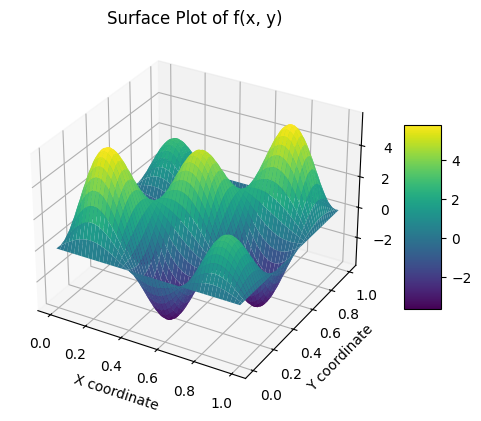

In [21]:
import sys
sys.path.append('cy/expression_tree')
from tree import evaluate_math_string

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit


def plot_surface(X, Y, Z):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the surface
  surf = ax.plot_surface(X, Y, Z, cmap='viridis')  # Use a colormap of your choice

  # Add color bar which maps values to colors
  fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

  # Labels and title
  ax.set_xlabel('X coordinate')
  ax.set_ylabel('Y coordinate')
  ax.set_zlabel('Z value')
  ax.set_title('Surface Plot of f(x, y)')

  plt.show()
  

# standing wave with higher-order harmonics
math_string = f'sin({np.pi} * x0) * sin({np.pi} * x1) +' \
              f'2 * sin(2 * {np.pi} * x0) * sin(2 * {np.pi} * x1) +' \
              f'4 * sin(3 * {np.pi} * x0) * sin(3 * {np.pi} * x1)'


x = np.linspace(0, 1, 5001)
y = np.linspace(0, 1, 5001)

# Create a meshgrid
X, Y = np.meshgrid(x, y)

# evaluate math string in Cython
print(f"Evaluating the the math string in {len(x) * len(y)} points.\n")
Z = evaluate_math_string(math_string, np.stack([X, Y], axis=-1))


plot_surface(X, Y, Z)

### 
<hr style="border:1px solid blue">

### 
# <u> What we have learned: </u>
### 1. `Cython` allows you to type declare your `Python` code which can lead to speedups.
### 2. Do not expect significant speedups if your code is bottlenecked by a `Numpy` operation in a loop.
### 3. Memoryviews allow you to implement `ndarray` operations in a `C`-style fashion, with `C` performance.
### 4. `Cython` gives you the tools to do even lower-level `C`-style programming while still allowing
### you to use the rich `Python` eccosystem in your code.
### 5. To benefit from all advanced `Cython` features, unlike in `Numba`, you have to **learn** `Cython`.
### 
<hr style="border:1px solid blue">

### 
## **I hope you enjoyed this seminar on advanced `Python` concepts.**
### 
### Here some additional techniques to speed up your code:
### 1. Binding a `C` code using the built-in `Python` module `ctypes`.
### 2. Binding `C++` using `Cython` (yes it can also do that) `pybind11`, `Boost.Python`, ...
### 3. Pypy